In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
# 수면상세 데이터 호출

df = pd.read_csv('./smcfb.01.195_수면상세.csv')

df

,user_id,date,time_stamp,sleep_stage,sleep_duration
0,smcfb.01.195,2024-05-29,-1,-1,-1
1,smcfb.01.195,2024-05-30,23:28:30.000,wake,30
2,smcfb.01.195,2024-05-30,23:29:00.000,light,300
3,smcfb.01.195,2024-05-30,23:34:00.000,deep,1950
4,smcfb.01.195,2024-05-30,00:06:30.000,light,1110
...,...,...,...,...,...
864,smcfb.01.195,2024-07-13,-1,-1,-1
865,smcfb.01.195,2024-07-14,-1,-1,-1
866,smcfb.01.195,2024-07-15,-1,-1,-1
867,smcfb.01.195,2024-07-16,-1,-1,-1


C:\Users\suhho\AppData\Local\Temp\ipykernel_36992\2248244417.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time_stamp'], errors='coerce')
C:\Users\suhho\AppData\Local\Temp\ipykernel_36992\2248244417.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sleep_duration'] = pd.to_numeric(df['sleep_duration'], errors='coerce')


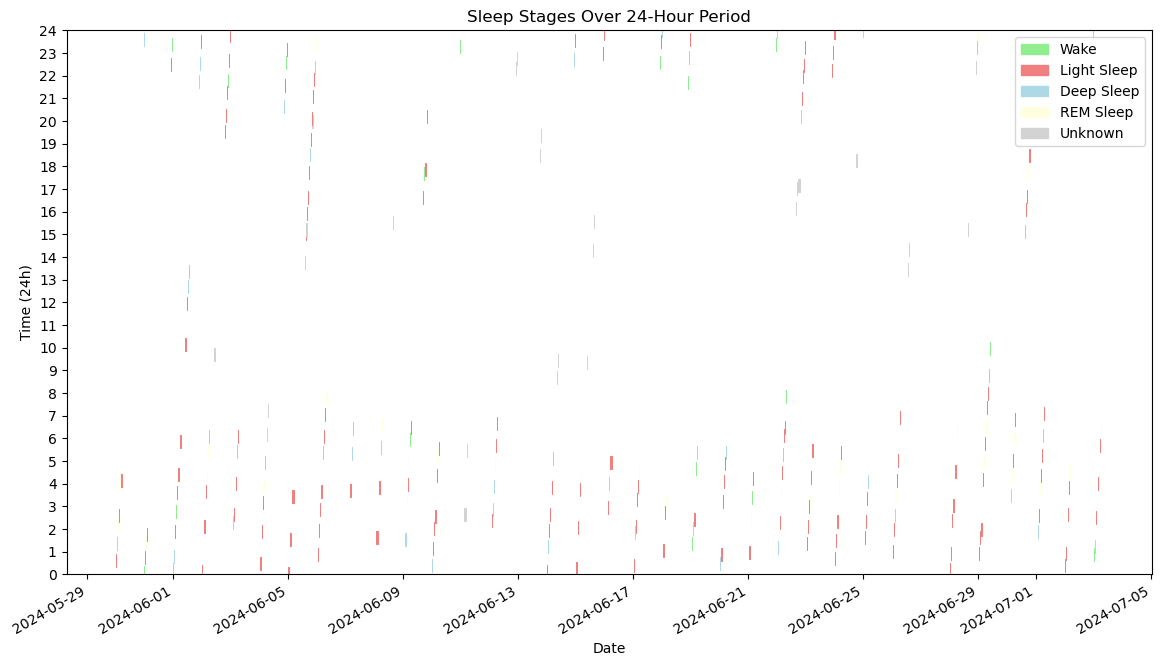

In [8]:
# date 를 그룹으로 묶기
import matplotlib.dates as mdates

def plot_sleep_stages_24h(df):
    try:
        # Combine date and time_stamp to create a datetime column
        df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time_stamp'], errors='coerce')

        # Filter out invalid datetime rows
        df = df.dropna(subset=['datetime'])

        # Ensure sleep_duration is numeric
        df['sleep_duration'] = pd.to_numeric(df['sleep_duration'], errors='coerce')

        # Remove rows with invalid sleep_duration
        df = df.dropna(subset=['sleep_duration'])

        # Add a new column for end time of each sleep stage
        df['end_time'] = df['datetime'] + pd.to_timedelta(df['sleep_duration'], unit='s')

        # Sort the DataFrame by datetime
        df = df.sort_values(by='datetime')

        # Define a categorical mapping for sleep stages
        sleep_stage_mapping = {
            'wake': 'Wake',
            'light': 'Light Sleep',
            'deep': 'Deep Sleep',
            'rem': 'REM Sleep'
        }
        
        df['label'] = df['sleep_stage'].map(sleep_stage_mapping).fillna('Unknown')

        # Set up the plot
        fig, ax = plt.subplots(figsize=(14, 8))

        # Define colors for sleep stages
        colors = {
            'Wake': mcolors.CSS4_COLORS['lightgreen'],
            'Light Sleep': mcolors.CSS4_COLORS['lightcoral'],
            'Deep Sleep': mcolors.CSS4_COLORS['lightblue'],
            'REM Sleep': mcolors.CSS4_COLORS['lightyellow'],
            'Unknown': mcolors.CSS4_COLORS['lightgrey']
        }

        # Plot each stage as a rectangle on the time axis (y-axis as 24-hour time)
        for index, row in df.iterrows():
            start_time = row['datetime'].time()
            end_time = row['end_time'].time()
            start = mdates.date2num(row['datetime'])
            end = mdates.date2num(row['end_time'])
            ax.plot([start, end], [start_time.hour + start_time.minute/60, start_time.hour + start_time.minute/60], 
                    color=colors.get(row['label'], 'grey'), linewidth=10, solid_capstyle='butt')

        # Formatting the x-axis as dates
        ax.xaxis_date()
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        fig.autofmt_xdate()

        # Formatting the y-axis as a 24-hour clock
        ax.set_yticks(range(0, 25, 1))
        ax.set_ylim(0, 24)

        # Set labels and title
        ax.set_xlabel('Date')
        ax.set_ylabel('Time (24h)')
        ax.set_title('Sleep Stages Over 24-Hour Period')

        # Create a legend
        patches = [mpatches.Patch(color=color, label=label) for label, color in colors.items()]
        ax.legend(handles=patches, loc='upper right')

        plt.show()
        
    except Exception as e:
        print(f"An error occurred: {e}")

plot_sleep_stages_24h(df)


In [9]:
def sleep_graph_ver(ax, slp_df, hrdf, start_date, end_date):
    title='Sleep graph for in 24 hours'

    try:
        # 시간 데이터 변환
        slp_df['converted_time'] = slp_df['time_stamp'].apply(normalize_time)
        slp_df['datetime'] = pd.to_datetime(slp_df['date'].dt.date.astype(str) + ' ' + slp_df['converted_time'], errors='coerce')
        hrdf['converted_time'] = hrdf['time_min'].apply(normalize_time)
        hrdf['datetime'] = pd.to_datetime(hrdf['date'].dt.date.astype(str) + ' ' + hrdf['converted_time'], errors='coerce')
        
        # start time 세팅
        date_range = pd.date_range(start=start_date, end=end_date, freq='T')  # 'T'는 분(minute) 단위를 의미합니다.
        
        df_based = pd.DataFrame(date_range, columns=['datetime'])

        # hr setting
        hrdf_datetimes = set(hrdf['datetime'])
        df_based['value'] = df_based['datetime'].apply(lambda x: 2 if x in hrdf_datetimes else 1)


        # 데이터 확장
        expanded_rows = []
        for _, row in slp_df.iterrows():
            start_datetime = row['datetime']
            duration_seconds = int(row['sleep_duration'])  # 'duration'은 초 단위로 주어짐
            end_datetime = start_datetime + pd.Timedelta(seconds=duration_seconds)

            # 시작 시간부터 종료 시간까지 모든 분 생성
            current_datetime = start_datetime
            while current_datetime < end_datetime:
                expanded_rows.append({
                    'datetime': current_datetime,
                    'sleep_stage': row['sleep_stage']
                })
                current_datetime += pd.Timedelta(minutes=1)

        # 확장된 데이터 프레임 생성
        expanded_df = pd.DataFrame(expanded_rows)
        expand_datetimes = set(expanded_df['datetime'])
        df_based['events'] = df_based['datetime'].apply(lambda x: 0 if x in expand_datetimes else None)
        df_based['value'] = df_based['events'].combine_first(df_based['value'])
        df_based.drop('events', axis=1, inplace=True)

        # 'datetime' 열을 datetime 객체로 변환
        df_based['datetime'] = pd.to_datetime(df_based['datetime'])

        # 데이터를 날짜와 시간으로 분리
        df_based['date'] = df_based['datetime'].dt.date
        df_based['hour'] = df_based['datetime'].dt.hour

        # 유니크한 날짜를 정렬하여 사용
        unique_dates = df_based['date'].unique()
        unique_dates.sort()

        ax.set_xticklabels([])
        # 각 날짜와 시간대별로 값 플롯
        for date in unique_dates:
            day_data = df_based[df_based['date'] == date]
            for hour in range(24):
                hour_data = day_data[day_data['hour'] == hour]
                # if not hour_data.empty:
                #     value = int(hour_data.iloc[0]['value'])  # 첫 번째 값을 사용하고 정수형으로 변환
                #     bars = ax.bar(date, 1, bottom=hour, color=['lightcoral', 'lightgray', 'lightgreen'][value % 3], align='edge')
                if not hour_data.empty:
                    value = int(hour_data.iloc[0]['value'])  # 첫 번째 값을 사용하고 정수형으로 변환
                    color = ['lightcoral', 'lightgray', 'lightgreen'][value % 3] if value in [0, 1, 2] else 'lightgray'
                    ax.bar(date, 1, bottom=hour, color=color, align='edge')
        

        # 그리드 설정
        ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
        ax.set_ylim(24, 0)
        ax.set_xlim(left=pd.to_datetime(start_date), right=pd.to_datetime(end_date))

        # 축 설정 후 그리드 활성화
        ax.xaxis.set_major_locator(mdates.DayLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.xticks(rotation=45)
        ax.set_xlabel('Date')
        ax.set_ylabel('Hour of Day')
        ax.xaxis.set_visible(False)
        ax.set_title(title, loc='left')
        return ax, df_based

    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None, None


In [ ]:
df_heart = fetch_patient_data(table_heart_rate, 'date', 'time_min',start_date=start_date, end_date=last_date)
df_sleep_detail = fetch_patient_data(table_sleep_detail, 'date','time_stamp',start_date=start_date, end_date=last_date)
ax4, df_based = function.sleep_graph_ver(ax4, df_sleep_detail, df_heart, start_date, last_date)